In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, mean_squared_error
from modelling_functions import *

## Processing for Models

In [2]:
#### Read Data files
housing, housing_features, feat_labels, dict_dictonary = read_and_clean(filepath = "../data/clean_train.csv")

C:\Users\Olympus\Project\machina_ex_kaggle\modelling\modelling_functions.py:110: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.col, id_dictonary = to_numeric(housing, col, 'SalePrice')


In [3]:
housing.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,60,2,65.0,8450,1,1,0,1,1,0,...,0,0,3,2,0,2,2008,1,2,12.247694
1,20,2,80.0,9600,1,1,0,1,1,0,...,0,0,3,2,0,5,2007,1,2,12.109011
2,60,2,68.0,11250,1,1,1,1,1,0,...,0,0,3,2,0,9,2008,1,2,12.317167
3,70,2,60.0,9550,1,1,1,1,1,0,...,0,0,3,2,0,2,2006,1,1,11.849398
4,60,2,84.0,14260,1,1,1,1,1,0,...,0,0,3,2,0,12,2008,1,2,12.429216


In [4]:
htest_id, htest_features, htest_labels, htest_dictonary = read_and_clean(filepath = "../data/clean_test.csv", test = True, dictonary = dict_dictonary)

C:\Users\Olympus\Project\machina_ex_kaggle\modelling\modelling_functions.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  housing.col, id_dictonary = to_numeric_test(housing, col, dictonary)


In [5]:
housing_features.lotarea = np.sqrt(housing_features.lotarea)
htest_features.lotarea = np.sqrt(htest_features.lotarea)

In [7]:
htrain, htest, ptrain, ptest = train_test_split(housing_features, housing.saleprice, test_size = 0.33)

(1455, 66)
(1459, 66)


## RandomForestRegressor

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 10000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32, 64]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 1288, 2377, 3466, 4555, 5644, 6733, 7822, 8911, 10000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 29, 48, 67, 86, 105, 124, 143, 162, 181, 200, None], 'min_samples_split': [2, 5, 10, 15, 20, 30, 40], 'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(htrain, ptrain)

In [9]:
rf_random.best_params_

{'n_estimators': 4555,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 162,
 'bootstrap': False}

In [ ]:
clf = RandomForestRegressor(n_estimators=4555, 
                            random_state=9, 
                            n_jobs=-1, 
                            min_samples_split = 2, 
                            min_samples_leaf = 1, 
                            max_features = 'sqrt', 
                            max_depth = 162,
                            bootstrap = False)
#sfm = SelectFromModel(clf, threshold = 0.01)
#sfm.fit(htrain, ptrain)
# ## Not Finished
# # Measure Feature Importance
#feature_selected = []
#for feature_list_index in sfm.get_support(indices=True):
#     feature_selected.append(feat_labels[feature_list_index])
#proxy = feature_selected
#trimmed = ['x1stflrsf', 'x2ndflrsf', 'garagecars', 'overallcond', 'saleprice', 'Unnamed: 0', 'bsmtfinsf1']
#testing = testing[proxy]
#housing_features = housing_features[trimmed_features]
#print(feature_selected)

In [ ]:
clf.fit(htrain, ptrain)

clf.score(htest, ptest)

NameError: name 'clf' is not defined

In [19]:
nice = clf.predict(htest)
mean_squared_error(nice, ptest)

0.022411580487852308

In [140]:
pred = np.exp(clf.predict(htest_features))
Submission(htest_id, pred)

## ElasticNet

In [164]:
regr = ElasticNetCV(alphas = [90e-6], 
                    l1_ratio = 1, 
                    cv = 5, 
                    n_jobs = -1,
                    n_alphas = 1,
                    normalize = True,
                    verbose = 0)

In [9]:
regr.fit(htrain, ptrain)

{'alpha': 1e-05}

ValueError: Invalid parameter alpha_ for estimator ElasticNetCV(alphas=array([1.00000e-09, 1.01109e-06, ..., 9.89899e-05, 1.00000e-04]),
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.9,
       max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [162]:
lasso = LinearRegression()
lasso.fit(htrain, ptrain)

print(lasso.score(htrain, ptrain))
print(lasso.score(htest, ptest))
pred = lasso.predict(htest)
rmsle(ptest.values,pred)
#print(selected_coefs)

0.010010373211258273

In [22]:
pred = np.exp(lasso.predict(htest_features))
Submission(htest_id, pred)

## Kaggle Scoring Metric

In [38]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

## KFolds Cross Validation

In [ ]:
from itertools import combinations
import random
combos = combinations(housing_features.columns,3)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
kf = KFold(n_splits=10,shuffle=True,random_state=0)
y = housing.saleprice
for i in random.sample(combos,k=int(len(combos)/1000)):           
    X = housing_features.loc[:,i]
    alphas = []
    R2 = []
    MSE = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        lm = optimize_penalty(X_train, y_train, model=Lasso, min_=1e-5, max_=1, step_=10, random=False, riter=100)
        alphas.append(lm.best_params_['alpha'])
        R2.append(lm.score(X_test, y_test))        
        MSE.append(mean_squared_error(y_test,lm.predict(X_test)))
    print('feat: ', i,'\nR2: ',round(np.mean(R2),4),'MSE: ',round(np.mean(MSE),4))

## Step Forwards

In [52]:
range(len(housing_features.columns.values))
X = housing_features
y = housing.saleprice

In [155]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
def run_kfolds(feat,splits):
    kf = KFold(n_splits=splits,shuffle=True,random_state=0)
    X = housing_features.loc[:,feat]
    MSE, kgs = [], []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        lm = optimize_penalty(X_train, y_train, model=Lasso, min_=1e-5, max_=1, step_=10, random=False, riter=100)
        kgs.append(rmsle(y_test.values, lm.predict(X_test)))
    return lm

In [54]:
regr.l1_ratio_

0.5

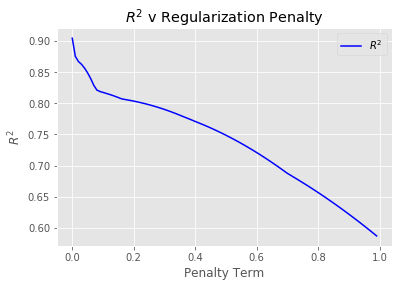

In [64]:
mask = np.ones(len(idx),dtype=bool)


In [107]:
alp.best_params_

AttributeError: 'tuple' object has no attribute 'best_params_'

In [154]:
lasso = Lasso(normalize=True)
lasso.set_params(alpha = 90e-6)
lasso.fit(htrain, ptrain)

print(lasso.score(htrain, ptrain))
print(lasso.score(htest, ptest))
#print(selected_coefs)
pred = lasso.predict(htest)
mean_squared_error(pred, ptest)

0.9167323779020945
0.90771667582178


0.014738153686995355

In [155]:
mean_squared_error(pred, ptest)

0.014738153686995355

In [82]:
testing.columns

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 'centralair',
       'electrical', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'x3ssnporch',
       'screenporch', 'poolarea', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition

In [32]:
run_kfolds(X.iloc[:,feat].columns.values, splits)

Index(['mssubclass', 'mszoning', 'lotarea', 'street', 'alley', 'lotshape',
       'landcontour', 'utilities', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'condition2', 'bldgtype', 'overallqual', 'overallcond',
       'yearbuilt', 'yearremodadd', 'roofstyle', 'roofmatl', 'exterior1st',
       'masvnrtype', 'masvnrarea', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc', 'centralair',
       'electrical', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr',
       'kitchenqual', 'totrmsabvgrd', 'functional', 'fireplaces',
       'fireplacequ', 'garagetype', 'garageyrblt', 'garagearea', 'paveddrive',
       'wooddecksf', 'openporchsf', 'enclosedporch', 'x3ssnporch',
       'screenporch', 'poolarea', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition

In [ ]:
pred = np.exp(model.predict(htest_features.iloc[:,feat]))
pred

In [ ]:
Submission(htest_id, pred)